<a href="https://colab.research.google.com/github/parashac/Violence-Detection-using-CCTV-footage/blob/main/finetune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import tensorflow as tf
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import TimeDistributed, Dropout, Flatten, LSTM, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

In [ ]:
IMG_SIZE = 224
FRAMES = 30
BATCH_SIZE = 8
NUM_CLASSES = 2
DATASET_PATH = "/content/drive/My Drive/violence-detection/frames_2"
CHECKPOINT_DIR = "/content/drive/My Drive/violence-detection/checkpoints"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

In [ ]:
def preprocess_frame(img):
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    eq = cv2.equalizeHist(gray)
    eq = eq.astype("float32") / 255.0
    eq = np.stack([eq, eq, eq], axis=-1)
    return eq

In [ ]:
def build_index(root_dir):
    samples, labels = [], []
    class_map = {"non-violence": 0, "violent": 1}
    for cls, label in class_map.items():
        cls_path = os.path.join(root_dir, cls)
        if not os.path.isdir(cls_path):
            continue
        for clip_folder in os.listdir(cls_path):
            clip_path = os.path.join(cls_path, clip_folder)
            if not os.path.isdir(clip_path):
                continue
            frame_files = [f for f in os.listdir(clip_path) if f.endswith(('.jpg', '.png'))]
            if len(frame_files) != FRAMES:
                continue  # skip corrupted clips
            full_paths = [os.path.join(clip_path, f) for f in sorted(frame_files)]
            samples.append(full_paths)
            labels.append(label)
    return samples, labels

In [ ]:
class VideoSequence(tf.keras.utils.Sequence):
    def __init__(self, samples, labels, batch_size=BATCH_SIZE, shuffle=True):
        self.samples = samples
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.num_samples = len(samples)
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(self.num_samples / self.batch_size))

    def on_epoch_end(self):
        self.indices = np.arange(self.num_samples)
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __getitem__(self, idx):
        batch_idx = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]
        X, y = [], []
        for i in batch_idx:
            clip_frames = []
            for frame_path in self.samples[i]:
                img = cv2.imread(frame_path)
                if img is None:
                    break
                clip_frames.append(preprocess_frame(img))
            if len(clip_frames) != FRAMES:
                continue
            X.append(np.array(clip_frames))
            y.append(self.labels[i])
        return np.array(X), tf.keras.utils.to_categorical(y, NUM_CLASSES)

In [ ]:
samples, labels = build_index(DATASET_PATH)
train_s, val_s, train_l, val_l = train_test_split(
    samples, labels, test_size=0.2, random_state=42, stratify=labels
)
train_gen = VideoSequence(train_s, train_l, batch_size=BATCH_SIZE)
val_gen = VideoSequence(val_s, val_l, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
mobilenet = MobileNetV2(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
mobilenet.trainable = False  # Phase-1 freeze
mobilenet.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
def create_lstm_model():
    model = Sequential([
        Input(shape=(FRAMES, IMG_SIZE, IMG_SIZE, 3)),
        TimeDistributed(mobilenet),
        TimeDistributed(GlobalAveragePooling2D()),
        LSTM(128, return_sequences=True, dropout=0.3),
        LSTM(64, dropout=0.3),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(NUM_CLASSES, activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                  loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = create_lstm_model()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 30, 7, 7, 1280) │     2,257,984 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 30, 1280)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 30, 128)        │       721,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,037,378 (11.59 MB)

 Trainable params: 779,394 (2.97 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
callbacks = [
    ModelCheckpoint(
        filepath=os.path.join(CHECKPOINT_DIR, "phase1_epoch{epoch:02d}.keras"),
        monitor="val_loss",
        save_best_only=False,
        verbose=1
    ),
    EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, verbose=1)
]

In [ ]:
history_phase1 = model.fit(train_gen, validation_data=val_gen, epochs=5, callbacks=callbacks)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 153s/step - accuracy: 0.5492 - loss: 0.6805  
Epoch 1: saving model to /content/drive/My Drive/violence-detection/checkpoints/phase1_epoch01.keras
58/58 ━━━━━━━━━━━━━━━━━━━━ 11485s 196s/step - accuracy: 0.5509 - loss: 0.6798 - val_accuracy: 0.6870 - val_loss: 0.6232 - learning_rate: 1.0000e-04
Epoch 2/5
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.6600 - loss: 0.6226 
Epoch 2: saving model to /content/drive/My Drive/violence-detection/checkpoints/phase1_epoch02.keras
58/58 ━━━━━━━━━━━━━━━━━━━━ 949s 16s/step - accuracy: 0.6606 - loss: 0.6222 - val_accuracy: 0.6870 - val_loss: 0.5998 - learning_rate: 1.0000e-04
Epoch 3/5
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.6835 - loss: 0.5875 
Epoch 3: saving model to /content/drive/My Drive/violence-detection/checkpoints/phase1_epoch03.keras
58/58 ━━━━━━━━━━━━━━━━━━━━ 949s 16s/step - accuracy: 0.6839 - loss: 0.5870 - val_accuracy: 0.6870 - val_loss: 0.5282 - learning_rate: 1.0000e-04
Epoch

In [ ]:
mobilenet.trainable = True
for layer in mobilenet.layers[:-40]:
    layer.trainable = False

# Recompile with smaller LR
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
callbacks_phase2 = [
    ModelCheckpoint(
        filepath=os.path.join(CHECKPOINT_DIR, "phase2_epoch{epoch:02d}.keras"),
        monitor="val_loss",
        save_best_only=False,
        verbose=1
    ),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, verbose=1)
]

In [ ]:
history_phase2 = model.fit(train_gen, validation_data=val_gen, epochs=12, callbacks=callbacks_phase2)

Epoch 1/8
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.7539 - loss: 0.5294 
Epoch 1: saving model to /content/drive/My Drive/violence-detection/checkpoints/phase2_epoch01.keras
58/58 ━━━━━━━━━━━━━━━━━━━━ 1465s 21s/step - accuracy: 0.7542 - loss: 0.5288 - val_accuracy: 0.8957 - val_loss: 0.3463 - learning_rate: 1.0000e-05
Epoch 2/8
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.8286 - loss: 0.4013 
Epoch 2: saving model to /content/drive/My Drive/violence-detection/checkpoints/phase2_epoch02.keras
58/58 ━━━━━━━━━━━━━━━━━━━━ 1198s 21s/step - accuracy: 0.8287 - loss: 0.4011 - val_accuracy: 0.8783 - val_loss: 0.3087 - learning_rate: 1.0000e-05
Epoch 3/8
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.8528 - loss: 0.3589 
Epoch 3: saving model to /content/drive/My Drive/violence-detection/checkpoints/phase2_epoch03.keras
58/58 ━━━━━━━━━━━━━━━━━━━━ 1167s 20s/step - accuracy: 0.8532 - loss: 0.3586 - val_accuracy: 0.8783 - val_loss: 0.2800 - learning_rate: 1.0000e-05
Epoch 4

In [ ]:
def plot_history(hist, name):
    plt.figure()
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'{name} Accuracy')
    plt.legend(['Train', 'Validation'])
    plt.tight_layout()
    plt.savefig(f"/content/drive/MyDrive/violence-detection/{name}_accuracy.png")
    plt.close()

    plt.figure()
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{name} Loss')
    plt.legend(['Train', 'Validation'])
    plt.tight_layout()
    plt.savefig(f"/content/drive/MyDrive/violence-detection/{name}_loss.png")
    plt.close()

plot_history(history_phase1, "phase1")
plot_history(history_phase2, "phase2")

15/15 ━━━━━━━━━━━━━━━━━━━━ 265s 14s/step
Confusion Matrix:
 [[17 19]
 [26 53]]

Classification Report:
               precision    recall  f1-score   support

           0       0.40      0.47      0.43        36
           1       0.74      0.67      0.70        79

    accuracy                           0.61       115
   macro avg       0.57      0.57      0.57       115
weighted avg       0.63      0.61      0.62       115

Weighted F1 Score: 0.6170


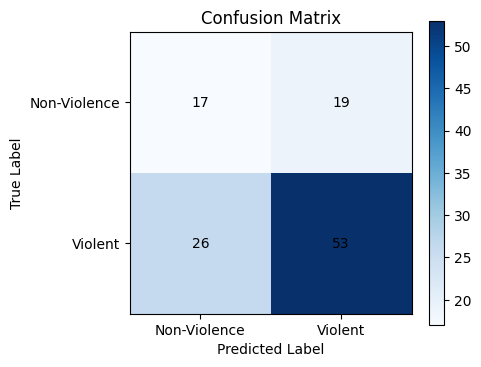

In [ ]:
y_pred = model.predict(val_gen, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(np.array([tf.keras.utils.to_categorical(l, NUM_CLASSES) for l in val_l]), axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
f1 = f1_score(y_true, y_pred_classes, average='weighted')

print("Confusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(y_true, y_pred_classes))
print(f"Weighted F1 Score: {f1:.4f}")

# Plot confusion matrix
plt.figure(figsize=(5, 4))
plt.imshow(cm, cmap='Blues')
plt.title("Confusion Matrix")
plt.colorbar()
classes = ["Non-Violence", "Violent"]
plt.xticks([0,1], classes)
plt.yticks([0,1], classes)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i,j], ha="center", va="center")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/violence-detection/confusion_matrix.png")
plt.show()

In [ ]:
plt.figure(figsize=(4,4))
plt.bar(["Weighted F1 Score"], [f1])
plt.ylim(0,1)
plt.title("F1 Score")
plt.text(0, f1 + 0.02, f"{f1:.2f}", ha='center')
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/violence-detection/f1_score.png")
plt.show()